# 前言
这是一个面向小白（我）理解并实现Transform的pytorch代码库。
最早出现写这个文档的想法是在听了好多相关的讲解后，感觉对于实现和训练还是毫无头绪。看了很多代码，还是感觉乱七八糟的。
所以尝试用自己的步骤理解一下每一段的含义。（其实，这是一个上班摸鱼的产物）
本文参考了几个博客以及其他的代码会在最后给出链接。
在这个代码库中，我根据transformer的结构，把系统拆成n个模块，然后再拼起来。
我会提供一些具体的语句解释和模块调用的用例～


# 整体结构划分

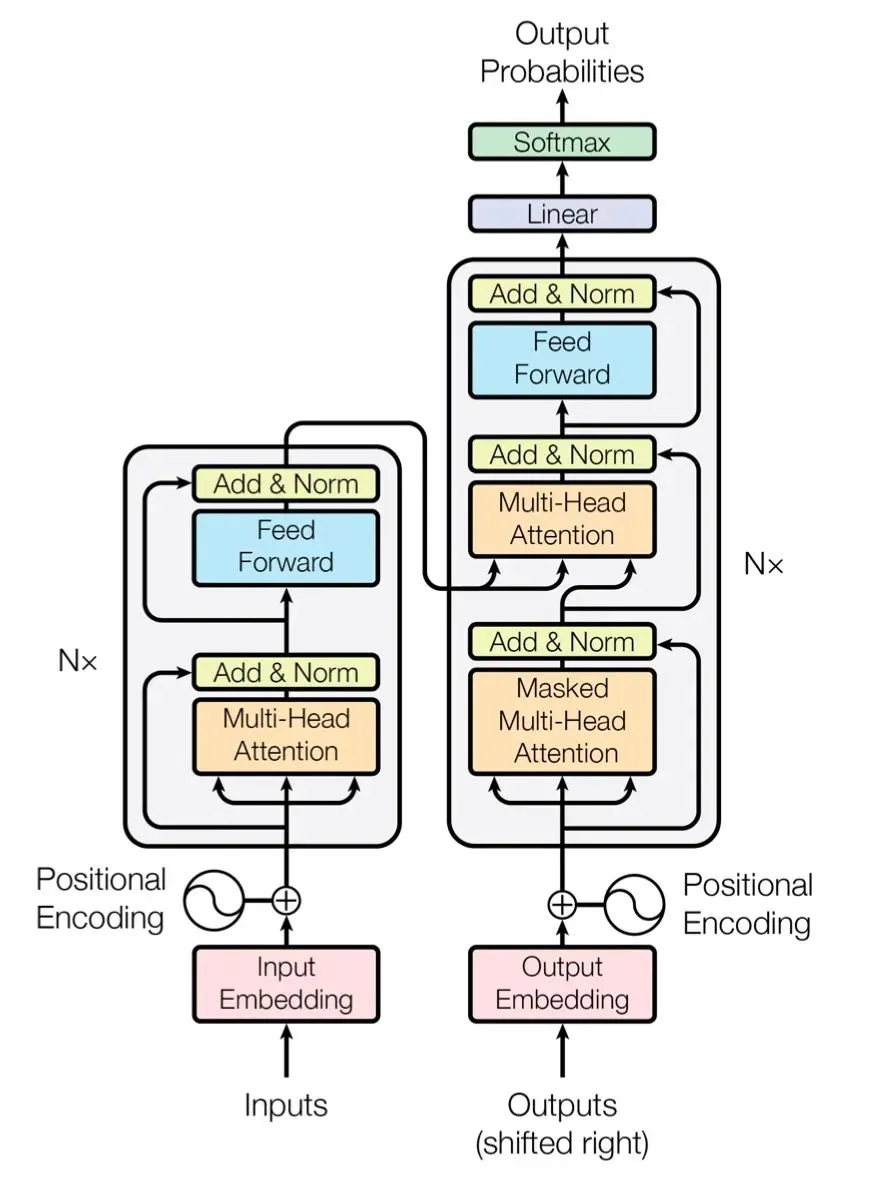

按照惯例用Transformer结构图镇楼。我把他拆成了几个模块：

1. 输入&输出的编码：包括Embedding和Positional Encoding

2. Encoder结构：包括多头Attention，Feed Forward、残差结构和层Norm

3. Decoder结构：本质上和Encoder一样，不过会多一些mask、不同qkv的多头Attention

4. 输出结构：包含一个线性层和一个softmax

# 包导入

下面是搭建模型需要的各种包。

In [2]:
import torch 
from torch import nn
import copy
import math
import numpy as np
import torch.nn.functional as F

# 输入&输出的编码

## Embedding结构
每一个输入的词我们称之为Vocab，Embedding就是把这个vocab编码成d_model（512）的长度，以供后续操作。

In [3]:
class Embeddings(nn.Module):
#可以理解为把词编程一个数组，也就是把vocab的每一个元素扩充成d_model的长度
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        #vocab=一共有多少个词，d_model=512和论文保持一致，作为配置项保证可变
        self.d_model = d_model
    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)
    #输出的尺寸是（1，vocab，d_model）

### Embedding用例

In [4]:
x = torch.randint(0,4,(1, 10)) 
#对于这个x里面的10，应该是需要和embedding里面的vocab是一样的，不然会报错，后面的尺寸
print(x)
embedding= Embeddings(10,4)
output=embedding(x)
print(output)
output.size()

tensor([[0, 0, 0, 1, 1, 0, 2, 2, 1, 0]])
tensor([[[ 0.7841,  4.5490, -2.8512, -0.5668,  0.7078, -3.7117, -0.0339,
           5.0829,  0.5801,  3.9657],
         [ 0.7841,  4.5490, -2.8512, -0.5668,  0.7078, -3.7117, -0.0339,
           5.0829,  0.5801,  3.9657],
         [ 0.7841,  4.5490, -2.8512, -0.5668,  0.7078, -3.7117, -0.0339,
           5.0829,  0.5801,  3.9657],
         [ 5.5898,  5.7821, -5.5240,  3.5161, -1.1640,  0.1694,  3.4070,
           4.1799,  2.9754,  1.0831],
         [ 5.5898,  5.7821, -5.5240,  3.5161, -1.1640,  0.1694,  3.4070,
           4.1799,  2.9754,  1.0831],
         [ 0.7841,  4.5490, -2.8512, -0.5668,  0.7078, -3.7117, -0.0339,
           5.0829,  0.5801,  3.9657],
         [-3.0623, -6.8018, -2.7744, -1.1991,  0.5353, -0.9488, -2.7739,
           0.6063,  4.0804,  1.3606],
         [-3.0623, -6.8018, -2.7744, -1.1991,  0.5353, -0.9488, -2.7739,
           0.6063,  4.0804,  1.3606],
         [ 5.5898,  5.7821, -5.5240,  3.5161, -1.1640,  0.1694,  3.4070

torch.Size([1, 10, 10])

## 位置编码结构

在一个句子里面，相同的词放在不同位置代表的含义是不一样的，所以需要通过一定的方式把每个词和他的位置联系起来

Transformer的方法是根据位置的sin/cos值来定义位置信息，计算后和输入加起来就是最终的输入。

**ToDo：CV里面实现transformer是不是也需要位置编码**

In [5]:
class PositionalEncoding(nn.Module): 
#这里可以魔改，实际上就是给上面那个输出加一个位置信息，以便后面训练
    def __init__(self, d_model, dropout, max_len=5000):
    #dropout率可配置
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
            -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        #pe[:, 0::2] = position
        pe[:, 1::2] = torch.cos(position * div_term)
        #pe[:, 1::2] = position
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        #怎么算的不知道，反正输出的结果就是文章里基于正弦余弦的公式
    def forward(self, x):
        #x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        x = x + self.pe[:, :x.size(1)]
        #如果你看到的代码里面有上面注释掉的Variable，去掉它。新版的torch不需要这个东西
        return self.dropout(x)
    #dropout 公式 输入*1/（1-p）

### 位置编码用例

In [6]:
pe=PositionalEncoding(4,0.1)
y = torch.ones( (1,10,4),dtype=int) 
print(y)
output1=pe(y)
print(output1)

tensor([[[1, 1, 1, 1],
         [1, 1, 1, 1],
         [1, 1, 1, 1],
         [1, 1, 1, 1],
         [1, 1, 1, 1],
         [1, 1, 1, 1],
         [1, 1, 1, 1],
         [1, 1, 1, 1],
         [1, 1, 1, 1],
         [1, 1, 1, 1]]])
tensor([[[1.1111, 2.2222, 1.1111, 2.2222],
         [2.0461, 1.7114, 1.1222, 2.2222],
         [2.1214, 0.6487, 1.1333, 2.2220],
         [1.2679, 0.0111, 1.1444, 2.2217],
         [0.2702, 0.3848, 0.0000, 2.2213],
         [0.0456, 1.4263, 1.1666, 2.2208],
         [0.8006, 2.1780, 1.1777, 2.2202],
         [1.8411, 1.9488, 1.1888, 2.2195],
         [2.2104, 0.9494, 0.0000, 2.2187],
         [1.5690, 0.0987, 1.2110, 2.2177]]])


## 输入部分整体用例

In [7]:
###用例：
vocab=4
d_model=10
input1 = torch.randint(0,vocab, (1, 10))
print(input1)
embedding= Embeddings(d_model,vocab)
output=embedding(input1)
print(output)
positionencode=PositionalEncoding(d_model,dropout=0.1)
output=positionencode(output)
print(output)

tensor([[0, 1, 3, 0, 0, 0, 1, 2, 1, 1]])
tensor([[[ 1.8123, -0.9585,  1.3807, -2.5367,  5.4719,  3.5880, -8.4727,
           3.6093, -1.9467, -1.8885],
         [ 0.7999, -0.1711, -3.0391, -0.0986, -1.4928, -3.1903, -4.1324,
           0.7309,  4.0235,  3.5866],
         [-2.7549, -0.8218, -1.2823, -1.7329, -1.7504, -2.5232,  6.5008,
          -2.6604,  0.3192, -2.1381],
         [ 1.8123, -0.9585,  1.3807, -2.5367,  5.4719,  3.5880, -8.4727,
           3.6093, -1.9467, -1.8885],
         [ 1.8123, -0.9585,  1.3807, -2.5367,  5.4719,  3.5880, -8.4727,
           3.6093, -1.9467, -1.8885],
         [ 1.8123, -0.9585,  1.3807, -2.5367,  5.4719,  3.5880, -8.4727,
           3.6093, -1.9467, -1.8885],
         [ 0.7999, -0.1711, -3.0391, -0.0986, -1.4928, -3.1903, -4.1324,
           0.7309,  4.0235,  3.5866],
         [ 2.1673,  0.3202,  2.0064, -3.3898, -4.4264,  1.0704,  3.7515,
          -0.2238,  3.6297,  2.2731],
         [ 0.7999, -0.1711, -3.0391, -0.0986, -1.4928, -3.1903, -4.1324

# 各种子模块的搭建

## 克隆模块

每个结构（图上的框会复制n次，为了省事搞了个自动复制，也可以自己一个个搭🤷）

In [8]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

## Attention结构

这就是本文的核心了，对于encoder来说qkv都是相等的。

对于decoder模块，第一层qkv是相等的，输入是mask后的output。第二层q和kv就不相等了，我个人的理解是这个时候要把输入和输出对应起来，也就是以output的特征为q，input为kv然后再进行attention，最后过feedforward进入输出阶段。

In [9]:
###我们先搭建一个attention的结构
def attention(query, key, value, mask=None, dropout=None):
    #首先取query的最后一维的大小，对应词嵌入维度
    d_k = query.size(-1)
    #按照注意力公式，将query与key的转置相乘，这里面key是将最后两个维度进行转置，再除以缩放系数得到注意力得分张量scores
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    
    #接着判断是否使用掩码张量
    if mask is not None:
        #这个就是说如果mask矩阵的某一位置等于0，那在score里面就会对应的把这个位置编程-1e9
        scores = scores.masked_fill(mask == 0, -1e9)
        
    #对scores的最后一维进行softmax操作，使用F.softmax方法，这样获得最终的注意力张量
    p_attn = nn.functional.softmax(scores, dim = -1)
    
    #之后判断是否使用dropout进行随机置0
    if dropout is not None:
        p_attn = dropout(p_attn)
    
    #最后，根据公式将p_attn与value张量相乘获得最终的query注意力表示，同时返回注意力张量
    return torch.matmul(p_attn, value), p_attn

In [10]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        #在类的初始化时，会传入三个参数，h代表头数，d_model论文里是512，dropout代表进行dropout操作时置0比率，默认是0.1
        super(MultiHeadedAttention, self).__init__()
        #在函数中，首先使用了一个测试中常用的assert语句，判断h是否能被d_model整除，这是因为我们之后要给每个头分配等量的词特征，也就是embedding_dim/head个
        assert d_model % h == 0
        #得到每个头获得的分割词向量维度d_k
        self.d_k = d_model // h
        #传入头数h
        self.h = h
        #创建linear层，通过nn的Linear实例化，它的内部变换矩阵是embedding_dim x embedding_dim，然后使用，为什么是四个呢，这是因为在多头注意力中，Q,K,V各需要一个，最后拼接的矩阵还需要一个，因此一共是四个
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        #self.attn为None，它代表最后得到的注意力张量，现在还没有结果所以为None
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
    def forward(self, query, key, value, mask=None):
        #前向逻辑函数，它输入参数有四个，前三个就是注意力机制需要的Q,K,V，最后一个是注意力机制中可能需要的mask掩码张量，默认是None
        if mask is not None:
            # Same mask applied to all h heads.
            #使用unsqueeze扩展维度，代表多头中的第n头
            mask = mask.unsqueeze(1)
        #接着，我们获得一个batch_size的变量，他是query尺寸的第1个数字，代表有多少条样本
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        # 首先利用zip将输入QKV与三个线性层组到一起，然后利用for循环，将输入QKV分别传到线性层中，做完线性变换后，开始为每个头分割输入，这里使用view方法对线性变换的结构进行维度重塑，多加了一个维度h代表头，这样就意味着每个头可以获得一部分词特征组成的句子，其中的-1代表自适应维度，计算机会根据这种变换自动计算这里的值，然后对第二维和第三维进行转置操作，为了让代表句子长度维度和词向量维度能够相邻，这样注意力机制才能找到词义与句子位置的关系，从attention函数中可以看到，利用的是原始输入的倒数第一和第二维，这样我们就得到了每个头的输入
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
                for l, x in zip(self.linears, (query, key, value))]

        # 2) Apply attention on all the projected vectors in batch. 
        # 得到每个头的输入后，接下来就是将他们传入到attention中，这里直接调用我们之前实现的attention函数，同时也将mask和dropout传入其中
        x, self.attn = attention(query, key, value, mask=mask,dropout=self.dropout)

        # 3) "Concat" using a view and apply a final linear. 
        # 通过多头注意力计算后，我们就得到了每个头计算结果组成的4维张量，我们需要将其转换为输入的形状以方便后续的计算，因此这里开始进行第一步处理环节的逆操作，先对第二和第三维进行转置，然后使用contiguous方法。这个方法的作用就是能够让转置后的张量应用view方法，否则将无法直接使用，所以，下一步就是使用view重塑形状，变成和输入形状相同。  
        x = x.transpose(1, 2).contiguous() \
            .view(nbatches, -1, self.h * self.d_k)
        #最后使用线性层列表中的最后一个线性变换得到最终的多头注意力结构的输出
        return self.linears[-1](x)

#### 多头用例
output是上一步用例我们的输入

In [11]:
query1= output
key1=output
value1=output
MH=MultiHeadedAttention(2,d_model)
attention_result=MH(query1,key1,value1)
print(attention_result)

tensor([[[-9.1566e-01,  7.9578e-01, -4.4062e-03,  1.0948e+00,  4.9025e-02,
           1.0612e+00, -1.7752e+00,  4.9829e-01, -1.8597e+00,  1.9558e-01],
         [ 1.1534e+00,  3.8186e-01, -4.3513e-01, -1.6702e-01, -2.0322e+00,
          -1.8283e-01,  8.7582e-01,  3.7270e-01,  8.9735e-01,  1.8849e+00],
         [ 2.1824e+00, -1.5873e+00,  1.1800e+00, -4.2100e-01,  1.8201e+00,
          -2.5050e+00,  2.3370e+00,  5.0558e-01,  2.9053e+00,  4.6163e-01],
         [-3.9895e+00,  2.4407e+00, -5.1804e-01,  3.6934e+00,  3.9009e-01,
           3.5197e+00, -5.7558e+00,  1.3279e+00, -6.1431e+00, -1.2795e+00],
         [-3.4387e+00,  1.8396e+00, -4.3265e-01,  3.3683e+00,  1.3618e-01,
           2.6923e+00, -4.6070e+00,  1.2307e+00, -5.0492e+00, -1.6600e+00],
         [-4.0574e+00,  2.4397e+00, -4.6105e-01,  3.7279e+00,  5.2007e-01,
           3.5295e+00, -5.7828e+00,  1.3803e+00, -6.1793e+00, -1.3307e+00],
         [ 1.6362e-01,  4.5336e-01,  2.1013e-01, -2.8556e-01, -1.7711e+00,
           3.0601e-

## Feedforward和Layer Norm
这一部分没什么好说的，就是两个结构，可以看comments

In [19]:
####这就是一个基础的全连接层，
class PositionwiseFeedForward(nn.Module): 
    ###d_model一如既往的512，d_ff是隐藏层的数量
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        #建两个
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))
####实现一个layernorm的层，我理解这东西就是切片的维度变了，具体哪更牛逼可以看文章理解，不求甚解的话就当个模块用就好了～
class LayerNorm(nn.Module):
    def __init__(self, feature_size, eps=1e-6):
        #features,表示词嵌入的维度，我理解这玩意和d_model是一样的
        #eps它是一个足够小的数，在规范化公式的分母中出现,防止分母为0，默认是1e-6。
        super(LayerNorm, self).__init__()
        #根据features的形状初始化两个参数张量a2，和b2，第一初始化为1张量，也就是里面的元素都是1，第二个初始化为0张量，也就是里面的元素都是0，这两个张量就是规范化层的参数。因为直接对上一层得到的结果做规范化公式计算，将改变结果的正常表征，因此就需要有参数作为调节因子，使其即能满足规范化要求，又能不改变针对目标的表征，最后使用nn.parameter封装，代表他们是模型的参数
        self.a_2 = nn.Parameter(torch.ones(feature_size))
        self.b_2 = nn.Parameter(torch.zeros(feature_size))
        #把eps传到类中
        self.eps = eps

    def forward(self, x):
    #输入参数x代表来自上一层的输出，在函数中，首先对输入变量x求其最后一个维度的均值，并保持输出维度与输入维度一致，接着再求最后一个维度的标准差，然后就是根据规范化公式，用x减去均值除以标准差获得规范化的结果。
    #最后对结果乘以我们的缩放参数，即a2,*号代表同型点乘，即对应位置进行乘法操作，加上位移参b2，返回即可
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        #print("mean:",mean)
        #print("std:",std)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2
#合并一下add&norm也就是一个残差结构，说人话就是把输入和输出加起来作为最终的输出，然后再用上面那个模块做层norm
class SublayerConnection(nn.Module):
    """ 
    实现子层连接结构的类
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):

        # 这个sublayer对应multihead/FCN
        sublayer_out = sublayer(x)
        x_norm = self.norm(x + self.dropout(sublayer_out))
        return x_norm

#### 这两个模块的用例

In [26]:
###这个调用的例子会比较清晰
###attention_result的格式是[1,10,4]，10是词的数量，4是特征数（d_model）
###mean是对这四个特征求平均，std也是一样，所以可以理解为是特征维度的norm，也就是layer norm，batch norm就是竖着算
print(attention_result)
PFF=PositionwiseFeedForward(10,1)
PFF_result=PFF(attention_result)
print(PFF_result)
LM=LayerNorm(feature_size=10)
Norm_result=LM(attention_result)
print(Norm_result)
SC=SublayerConnection(10,0.01)
SC_result=SC(output,lambda output: MH(output, output, output))
#必须要这样调用，我不知道为啥，我再研究研究。
#目前的猜想是上面定义的时候用的sublayer字段，如果直接用tensor就没事。不过后面可以看下为啥这地方要这么定义～
##SC_result=SC(attention_result,PFF_result)这种不行
print(SC_result)

tensor([[[-9.1566e-01,  7.9578e-01, -4.4062e-03,  1.0948e+00,  4.9025e-02,
           1.0612e+00, -1.7752e+00,  4.9829e-01, -1.8597e+00,  1.9558e-01],
         [ 1.1534e+00,  3.8186e-01, -4.3513e-01, -1.6702e-01, -2.0322e+00,
          -1.8283e-01,  8.7582e-01,  3.7270e-01,  8.9735e-01,  1.8849e+00],
         [ 2.1824e+00, -1.5873e+00,  1.1800e+00, -4.2100e-01,  1.8201e+00,
          -2.5050e+00,  2.3370e+00,  5.0558e-01,  2.9053e+00,  4.6163e-01],
         [-3.9895e+00,  2.4407e+00, -5.1804e-01,  3.6934e+00,  3.9009e-01,
           3.5197e+00, -5.7558e+00,  1.3279e+00, -6.1431e+00, -1.2795e+00],
         [-3.4387e+00,  1.8396e+00, -4.3265e-01,  3.3683e+00,  1.3618e-01,
           2.6923e+00, -4.6070e+00,  1.2307e+00, -5.0492e+00, -1.6600e+00],
         [-4.0574e+00,  2.4397e+00, -4.6105e-01,  3.7279e+00,  5.2007e-01,
           3.5295e+00, -5.7828e+00,  1.3803e+00, -6.1793e+00, -1.3307e+00],
         [ 1.6362e-01,  4.5336e-01,  2.1013e-01, -2.8556e-01, -1.7711e+00,
           3.0601e-

## Mask模块
在Transformer结构图的右侧我们能看到，之前的输出也会被输入到模型里面，但是训练的时候我们是不希望T时刻后面的输出参与训练的，因此需要把后面的东西隐藏掉，这个隐藏的过程通过mask来实现。

In [16]:
#下面就是定义mask 模块，在transformer里面可以理解为输入和输出都会被扔进网络进行预测，但是输出得把当前词以后的词盖上。
#举个例子：当翻译“我是天才”的时候，在某一时刻的输入是：“我是天才”，上一步的输出是“I am”，这个时候得把Genius这个词盖上让他来训练
#不能名排告诉模型有关他还没开始翻译的这些信息
def subsequent_mask(size):
    #生成向后遮掩的掩码张量，参数size是掩码张量最后两个维度的大小，它最后两维形成一个方阵

    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    #size是你要掩盖的tensor最后两个维度的大小
    
    #然后使用np.ones方法向这个形状中添加1元素，形成上三角阵
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')

    #最后将numpy类型转化为torch中的tensor，内部做一个1- 的操作。这个其实是做了一个三角阵的反转，subsequent_mask中的每个元素都会被1减。
    #如果是0，subsequent_mask中的该位置由0变成1
    #如果是1，subsequect_mask中的该位置由1变成0
    return torch.from_numpy(subsequent_mask) == 0

#### Mask用例

In [18]:
maskinput=torch.randn(3,3)
masktest=subsequent_mask(3)
maskoutput=maskinput.masked_fill(masktest,0)
print(maskinput)
print(masktest)
print(maskoutput)

tensor([[ 1.9044, -2.2668,  0.9205],
        [ 1.2766, -0.4098, -0.8931],
        [-0.1515, -0.3619, -0.7195]])
tensor([[[ True, False, False],
         [ True,  True, False],
         [ True,  True,  True]]])
tensor([[[ 0.0000, -2.2668,  0.9205],
         [ 0.0000,  0.0000, -0.8931],
         [ 0.0000,  0.0000,  0.0000]]])


到这个位置，所有的小模块就都完成了。下一步就可以直接搭积木了！

# Encoder结构

在图里我们能看到有N个Encoder大模块，所以我们先定义一个大模块，即：EncoderLayer

结构很简单，先多头，然后add&norm，再Feed Forward，然后add&norm

In [18]:
class EncoderLayer(nn.Module):
    "EncoderLayer is made up of two sublayer: self-attn and feed forward"                                                                                                         
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        ##有两个ad&norm，上面两个分别对应一个：atten+sub+forward+sub
        self.size = size   # embedding's dimention of model, 默认512

    def forward(self, x, mask):
        #mask在encoder是置False的
        # attention sub layer
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        ##LAMBDA这东西后面的可以理解为一个用一次就不存起来的变量
        # feed forward sub layer
        z = self.sublayer[1](x, self.feed_forward)
        return z


然后就可以把上面那个模块重复N次，然后最终的输出再处理一个LayerNorm。

**注意：这里用的LayeNorm，不是残差**

In [27]:
class Encoder(nn.Module):
    """
    Encoder
    The encoder is composed of a stack of N=6 identical layers.
    """
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        # 调用时会将编码器层传进来，我们简单克隆N分，叠加在一起，组成完整的Encoder
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

# Decoder模块

逻辑和上面的是一样的，详情参见注释～

In [20]:
#然后是解码器层
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        #初始化函数的参数有5个，分别是size，代表词嵌入的维度大小，同时也代表解码器的尺寸，
        #第二个是self_attn，多头自注意力对象，也就是说这个注意力机制需要Q=K=V，
        #第三个是src_attn,多头注意力对象，这里Q!=K=V，就是对多头的不同使用方式
        #第四个是前馈全连接层对象，最后就是dropout置0比率
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        #按照结构图使用clones函数克隆三个子层连接对象
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
        #看结构图，上面三个层每个都连一个add&norm
 
    def forward(self, x, memory, src_mask, tgt_mask):
        #forward函数中的参数有4个，分别是来自上一层的输入x，来自编码器层的语义存储变量memory，
        #以及源数据掩码张量和目标数据掩码张量，将memory表示成m之后方便使用。
        m = memory
        #将x传入第一个子层结构，第一个子层结构的输入分别是x和self-attn函数，因为是自注意力机制，所以Q,K,V都是x，
        #最后一个参数时目标数据掩码张量，这时要对目标数据进行遮掩，因为此时模型可能还没有生成任何目标数据。
        #比如在解码器准备生成第一个字符或词汇时，我们其实已经传入了第一个字符以便计算损失，
        #但是我们不希望在生成第一个字符时模型能利用这个信息，因此我们会将其遮掩，
        #同样生成第二个字符或词汇时，模型只能使用第一个字符或词汇信息，第二个字符以及之后的信息都不允许被模型使用。
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        #接着进入第二个子层，这个子层中常规的注意力机制，q是输入x;k,v是编码层输出memory，同样也传入source_mask，
        #但是进行源数据遮掩的原因并非是抑制信息泄露，而是遮蔽掉对结果没有意义的padding。
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        #m就是encoder传过来的，x就是output的多头注意力，看那个图理解 
        #最后一个子层就是前馈全连接子层，经过它的处理后就可以返回结果，这就是我们的解码器结构
        return self.sublayer[2](x, self.feed_forward)

In [19]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        #初始化函数的参数有两个，第一个就是解码器层layer，第二个是解码器层的个数N
        super(Decoder, self).__init__()
        #首先使用clones方法克隆了N个layer，然后实例化一个规范化层，因为数据走过了所有的解码器层后最后要做规范化处理。
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        #forward函数中的参数有4个，x代表目标数据的嵌入表示，memory是编码器层的输出，source_mask，target_mask代表源数据和目标数据的掩码张量，然后就是对每个层进行循环，当然这个循环就是变量x通过每一个层的处理，得出最后的结果，再进行一次规范化返回即可。
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

# 输出层

最后一个层，扔进去Linear一下，把维度从d_model降维到vocab大小，然后过softmax就可以输出下一个词的概率了

In [21]:
###然后定义输出，图中的Linear和Softmax
class Generator(nn.Module):
    def __init__(self, d_model, vocab):
        #初始化函数的输入参数有两个，d_model代表词嵌入维度，vocab.size代表词表大小
        super(Generator, self).__init__()
        #首先就是使用nn中的预定义线性层进行实例化，得到一个对象self.proj等待使用
        #这个线性层的参数有两个，就是初始化函数传进来的两个参数：d_model，vocab_size
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        #前向逻辑函数中输入是上一层的输出张量x,在函数中，首先使用上一步得到的self.proj对x进行线性变化,
        #然后使用F中已经实现的log_softmax进行softmax处理。
        return F.log_softmax(self.proj(x), dim=-1)


# 模型搭建

In [31]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. 
    Base for this and many other models.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        #初始化函数中有5个参数，分别是编码器对象，解码器对象,源数据输入，目标数据输入，以及输出部分的类别生成器对象.
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed    # input embedding module(input embedding + positional encode)
        self.tgt_embed = tgt_embed    # ouput embedding module
        self.generator = generator    # output generation module
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        #在forward函数中，有四个参数，source代表源数据，target代表目标数据,
        #source_mask和target_mask代表对应的掩码张量,
        #在函数中，将source source_mask传入编码函数，得到结果后与source_mask target 和target_mask一同传给解码函数
        memory = self.encode(src, src_mask)
        res = self.decode(memory, src_mask, tgt, tgt_mask)
        return res
    
    def encode(self, src, src_mask):
        #编码函数，以source和source_mask为参数,使用src_embed对source做处理，然后和source_mask一起传给self.encoder
        src_embedds = self.src_embed(src)
        return self.encoder(src_embedds, src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        #解码函数，以memory即编码器的输出，source_mask target target_mask为参数,使用tgt_embed对target做处理，然后和source_mask,target_mask,memory一起传给self.decoder
        target_embedds = self.tgt_embed(tgt)
        return self.decoder(target_embedds, memory, src_mask, tgt_mask)


In [30]:
def make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1):
    """
    构建模型
    params:
        src_vocab:
        tgt_vocab:
        N: 编码器和解码器堆叠基础模块的个数
        d_model: 模型中embedding的size，默认512
        d_ff: FeedForward Layer层中embedding的size，默认2048
        h: MultiHeadAttention中多头的个数，必须被d_model整除
        dropout:
    """
    c = copy.deepcopy
    ##我们之前用过，就是复制，定义的原因是简化
    attn = MultiHeadedAttention(h, d_model)
    ##给attn初始值
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    ##给前馈初始值
    position = PositionalEncoding(d_model, dropout)
    ##给PE初始值
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))
    ##这里比较重要，我们看看他在干嘛
    ##EncoderDecoder这个东西需要四个参数，
    ###其实就是图里的五个模块
    ##nn.Sequential(Embeddings(d_model, src_vocab), c(position))这个就是把输入按顺序扔进我们的Embedding和position
    ##nn.Sequential(Embeddings(d_model, tgt_vocab), c(position))这个同理，只不过换成输出
    
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

In [26]:
def inference_test():
    test_model = make_model(11, 11, 2)
    test_model.eval()
    src = torch.LongTensor([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]])
    src_mask = torch.ones(1, 1, 10)

    memory = test_model.encode(src, src_mask)
    ys = torch.zeros(1, 1).type_as(src)

    for i in range(10):
        out = test_model.decode(
            memory, src_mask, ys, subsequent_mask(ys.size(1)).type_as(src.data)
        )
        prob = test_model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data[0]
        ys = torch.cat(
            [ys, torch.empty(1, 1).type_as(src.data).fill_(next_word)], dim=1
        )

    print("Example Untrained Model Prediction:", ys)


def run_tests():
    for _ in range(10):
        inference_test()


def show_example(fn, args=[]):
    if __name__ == "__main__" :
        return fn(*args)

show_example(run_tests)

Example Untrained Model Prediction: tensor([[ 0, 10,  2, 10,  2, 10,  2, 10,  2, 10,  2]])
Example Untrained Model Prediction: tensor([[ 0,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10]])
Example Untrained Model Prediction: tensor([[0, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3]])
Example Untrained Model Prediction: tensor([[0, 4, 9, 4, 9, 4, 9, 4, 9, 4, 9]])
Example Untrained Model Prediction: tensor([[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]])
Example Untrained Model Prediction: tensor([[0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]])
Example Untrained Model Prediction: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
Example Untrained Model Prediction: tensor([[0, 8, 9, 8, 9, 8, 9, 8, 9, 8, 9]])
Example Untrained Model Prediction: tensor([[0, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4]])
Example Untrained Model Prediction: tensor([[ 0,  6, 10,  8,  6, 10,  1,  7, 10,  1,  7]])
